# Neural Networks for Data Science Applications
## Homework 1: Customized activation functions

**Name**: *\<Ehsan Mokhtari\>*

**Matricola**: *\<2108539\>*

> ✍ Upload the completed notebook **before 13/11/2024 at 23:59** on the Google Classroom page.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**) and 1 optional exercise. The optional one is ungraded but I may take it into consideration for the final mark during the oral.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. Marks between 4 and 5 can be fully recovered during the oral examination.
3. If you want to improve the mark, you are also free to complete the full EoT homework to recover a full mark.
3. The grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (except where specified) while vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

### Introduction: Trainable activation functions

Remember that a trainable variant of the Swish function can be written as:

$$ \phi(s) = (as + b)\sigma(cs + d) $$

where $s$ is the scalar input of the AF, $\left\{a, b, c, d\right\}$ are four scalar parameters, and $\sigma$ is the sigmoid function. Note how this can be (roughly) interpreted as a one-hidden layer MLP with one input, one hidden unit, and one output. Thus, we can easily generalize this as:

$$ \phi(s) = \sum_{i=1}^n (a_is+b_i)\sigma(c_is+d_i) \tag{1} $$

where $n$ is an hyper-parameter, and the function has now $4n$ parameters $\left\{a_i, b_i, c_i, d_i\right\}_{i=1}^n$. By varying $n$ we can make the activation function as complicated as we want: we say this is a **non-parametric** AF [1]. The homework will guide you to implement an MLP exploiting (1) in JAX.

In [1]:
import jax
from jax import vmap, random, grad, value_and_grad
import jax.numpy as jnp
from jaxtyping import Array, Float
import matplotlib.pyplot as plt #for ploting

### Exercise 1 (1 point)

We begin by implementing (1) (no MLPs for now) in JAX. Following what we saw in the first lab session, implement equation (1) in pure JAX (no external libraries) using a pair of (init, call) functions, respectively for initializing the parameters and for computing the outputs of the AF.

For the purpose of this exercise we consider a single AF with mini-batching over the input, hence the signature of the functions should be:

```
def init_fcn(key, n):
   # key is the PNRG state
   # n is the hyper-parameter in (1)
   # Returns: the parameters (a,b,c,d) in whatever format you prefer.
```


```
def call_fcn(params, x: Float[Array, "b"])
           -> Float[Array, "b"]:
   # x is a vector (mini-batch) of b inputs to the function
   # params is the output of init_fcn
   # Returns the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).
```






✅ **Completion requirement**: Show me the two functions work as expected. For example, you can plot some randomly-initialized functions for different choices of $n$.

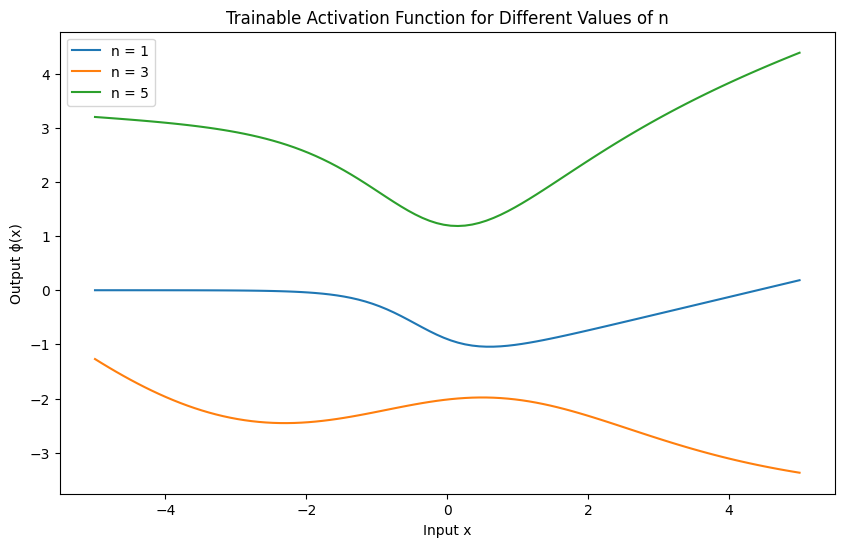

In [2]:
# Define the initialization function (init_fcn)
def init_fcn(key, n):

    #I need a 1D array with n elements", which corresponds to the number of terms we are summing over
    #in the activation function. Each of those n terms will have its own set of parameters ai,bi,ci,di.
    shape = (n,)
    # we define 4 different keys because every key generates same random numbers because jax is pure
    key_a, key_b, key_c, key_d = random.split(key, 4)

    a = random.normal(key_a, shape)
    b = random.normal(key_b, shape)
    c = random.normal(key_c, shape)
    d = random.normal(key_d, shape)
    
    return (a, b, c, d)


# Define the call function (call_fcn)
def call_fcn(params, x: Float[Array, "b"]) -> Float[Array, "b"]:

    # Unpack parameters
    a, b, c, d = params
    result = jnp.zeros_like(x)

    #iterate over params and calculate the sum or formula (1)
    for i in range(len(a)):
        linear_term = a[i] * x + b[i]
        sigmoid_term = 1 / (1 + jnp.exp(-(c[i] * x + d[i])))
        result += linear_term * sigmoid_term
    
    return result


# Set random seed and key
key = random.PRNGKey(0)


#for ploting section, i get some help from chat-gpt
# Define a range of x values (input values)
x_values = jnp.linspace(-5, 5, 100)

# Plot activation functions for different values of n
plt.figure(figsize=(10, 6))

for n in [1, 3, 5]:  # Different values of n (number of terms in the sum)
    params = init_fcn(key, n)  # Initialize parameters for each n
    y_values = call_fcn(params, x_values)  # Compute the output of the activation function
    plt.plot(x_values, y_values, label=f"n = {n}")

plt.title("Trainable Activation Function for Different Values of n")
plt.xlabel("Input x")
plt.ylabel("Output ϕ(x)")
plt.legend()
plt.show()

### Exercise 2 (1 point)

One issue of non-parametric AF is that they tend to work poorly when randomly-initialized. However, it is relatively easy to fix the parameters of (1) so that the initialized functions approximate any scalar function we desire (in fact, (1) for $n \rightarrow \infty$ is a universal approximator for 1D functions).

For this exercise, write a gradient descent procedure (again, pure JAX) that given $n$ finds the optimal coefficients $\left\{a_i, b_i, c_i, d_i\right\}$ such that:

$$ \phi(s) \approx \text{ReLU}(s) $$

Note that all functions from Exercise 1 and 2 should be scalar-valued apart from mini-batching.

✅ **Completion requirement**: Show me gradient descent converges correctly. For example, you can plot the quality of the approximation when increasing $n$.

C:\Users\sherl\AppData\Local\Temp\ipykernel_6184\3159477937.py:29: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  params = jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


Step 0, Loss: 64.23751068115234
Step 100, Loss: 0.13903824985027313
Step 200, Loss: 0.07295351475477219
Step 300, Loss: 0.04238813370466232
Step 400, Loss: 0.027125218883156776
Step 500, Loss: 0.019003162160515785
Step 600, Loss: 0.014483648352324963
Step 700, Loss: 0.011867642402648926
Step 800, Loss: 0.010284977033734322
Step 900, Loss: 0.009273403324186802


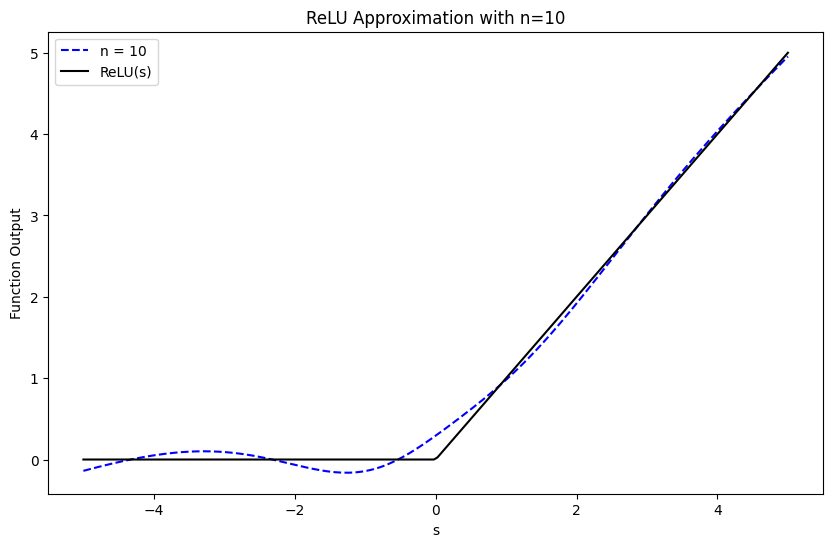

In [3]:
# Define relu function as the target we want to approximate
def relu(s):
    return jnp.maximum(0, s)

# Define the loss function as the mean squared error between call_fcn and relu
@jax.jit
def loss_fn(params, x_values):
    # Target values are relu(x_values)
    target = relu(x_values)
    # Predicted values are call_fcn(params, x_values)
    predictions = call_fcn(params, x_values)
    # Mean Squared Error (MSE) loss
    return jnp.mean((predictions - target) ** 2)

# Gradient descent procedure to train the parameters
def train(key, n, learning_rate=0.01, steps=1000):
    # Initialize parameters using the init_fcn function
    params = init_fcn(key, n)
    # Create a range of x values (e.g., from -5 to 5) for training
    x_values = jnp.linspace(-5, 5, 100)

    # Compute both loss and gradient using value_and_grad
    loss_and_grad_fn = jax.jit(value_and_grad(loss_fn))  # JIT only the loss and gradient calculation

    # Gradient descent loop
    for step in range(int(steps)):  # Ensure steps is concrete by casting to int
        loss, grads = loss_and_grad_fn(params, x_values)  # Compute loss and gradients
        # Update parameters in a single operation using jax.tree_map
        params = jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

        # Print the loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss}")

    return params

#for ploting section i get help from chat-gpt
# Plot function, adjusted to accept pre-trained parameters
def plot_relu_approximation(trained_params, n):
    # Generate a range of x values for plotting
    x_values = jnp.linspace(-5, 5, 200)
    relu_values = relu(x_values)  # Target ReLU values for comparison

    approx_values = call_fcn(trained_params, x_values)

    plt.figure(figsize=(10, 6))
    # Plot the approximation
    plt.plot(x_values, approx_values, label=f"n = {n}", linestyle='--', color='blue')
    # Plot the target ReLU function for comparison
    plt.plot(x_values, relu_values, color="black", label="ReLU(s)")
    plt.xlabel("s")
    plt.ylabel("Function Output")
    plt.title(f"ReLU Approximation with n={n}")
    plt.legend()
    plt.show()

# Usage example
key = jax.random.PRNGKey(0)           # Random key for reproducibility
n = 10                                # Single value of n to test approximation quality
trained_params = train(key, n)  # Train with the optimized function
plot_relu_approximation(trained_params, n) # Plot the trained approximation

### Exercise 3 (1 point)

Clearly, a single activation function is not enough. For example, consider the following Sequential model in Keras:

```
model = Sequential([
  Dense(5),
  ReLU(),
  Dense(1)  
])
```
We would like to replace the intermediate ReLU layer with an equivalent layer implementing (1), where each unit (neuron) in the layer is assigned a different AF. Luckily, we can use `jax.vmap` over the result of Exercise 1 to solve this.

For this exercise, apply `vmap` over `call_fcn` to obtain the following variants:

1.   A single AF (shared parameters) for all the units of the layer.
2.   Different AFs (different parameters) for each unit in the layer.
3. (**Optional, more difficult**) A KAN-style AF [2] where a different AF is applied to each edge of a fully-connected layer.

The signature of all vmapped functions should be:

```
def vmapped_call_fcn(params, x: Float[Array, "b h"])
           -> Float[Array, "b h"]:
   ...
```
where $x$ is a generic output of a fully-connected layer, so that $h$ is the number of hidden units in the layer (e.g., $h=5$ for the first `Dense` layer above). For the new initialization functions, you are free to either rewrite them or find some way to vectorize the original one.

✅ **Completion requirement**: Show me the vectorization works as expected (e.g., generate and visualize multiple functions simultaneously).

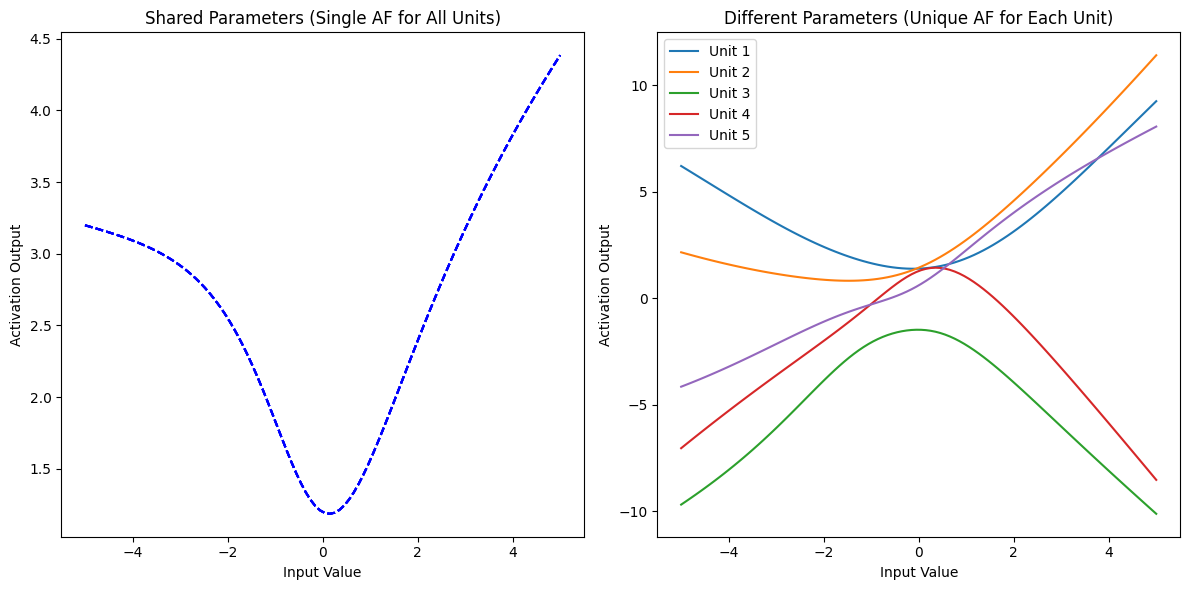

In [4]:
#1: Shared Parameters for All Units (Single AF)
def vmapped_call_fcn_shared(params, x):
 
    # Apply the shared activation function to all units at once
    return call_fcn(params, x)  # Just apply the shared params to all units

#2: Different Parameters for Each Unit
def vmapped_call_fcn_different(params, x):
    
    return vmap(call_fcn, in_axes=(0, 1), out_axes=1)(params, x)

# Initialization functions
def init_fcn_shared(key, n):
    # Initialize a single set of parameters for shared AF
    return init_fcn(key, n)

def init_fcn_different(key, h, n):
    # Initialize distinct parameters for each unit in the layer
    keys = jax.random.split(key, h)
    return jnp.array([init_fcn(k, n) for k in keys])

# Visualization to confirm the vectorization
def plot_vmapped_functions(shared_outputs, different_outputs, x_values):
    """
    Plots the output of the shared and different parameter functions.
    """
    plt.figure(figsize=(12, 6))
    
    # Shared parameters plot
    plt.subplot(1, 2, 1)
    plt.plot(x_values, shared_outputs, label="Shared Parameters AF", color='blue', linestyle='--')
    plt.title("Shared Parameters (Single AF for All Units)")
    plt.xlabel("Input Value")
    plt.ylabel("Activation Output")
    
    # Different parameters plot
    plt.subplot(1, 2, 2)
    for i in range(different_outputs.shape[1]):
        plt.plot(x_values[:, 0], different_outputs[:, i], label=f"Unit {i+1}")
    plt.title("Different Parameters (Unique AF for Each Unit)")
    plt.xlabel("Input Value")
    plt.ylabel("Activation Output")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example
key = jax.random.PRNGKey(0)
n = 5
h = 5  # Number of hidden units
batch_size = 100

# Generate x values for visualization (range from -5 to 5)
x_values = jnp.linspace(-5, 5, batch_size).reshape(batch_size, 1)
x_values = jnp.tile(x_values, (1, h))  # Repeat for each unit in the layer

# Initialize parameters
shared_params = init_fcn_shared(key, n)
different_params = init_fcn_different(key, h, n)

# Compute function outputs using the shared and different parameters
shared_outputs = vmapped_call_fcn_shared(shared_params, x_values)
different_outputs = vmapped_call_fcn_different(different_params, x_values)

# Plot the vmapped function results
plot_vmapped_functions(shared_outputs, different_outputs, x_values)

### Exercise 4 (2 point)

It is now time to train an MLP with our new activation functions. To begin with, select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

The objective of the exercise is to train an MLP with one hidden layer having as activation functions (1). In order to do this you have multiple choices:

1. You can do this completely in JAX by defining a new pair of (init, call) functions describing the complete model and performing gradient descent with these.
2. If you want to use Keras (note: `.fit` is *not allowed*) as in the second lab session, you need to port the trainable function in Keras. My suggestion is to subclass the `Layer` object by wrapping the functions you have already created (https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The resulting layer will be backend-specific, which is not an issue. If you want something slightly harder, you can rewrite everything with Keras ops to make it backend-agnostic.
3. You can also use some high-level JAX library (e.g., Equinox, Haiku, ...). In this case, please document the code precisely.

✍ **DESCRIPTION OF THE DATASET**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: Iris dataset : the dataset consists of 150 samples of iris flowers, categorized into three species: Setosa, Versicolor, and Virginica. Each sample is represented by four features: the length and width of both the sepals and petals, measured in centimeters. These features are numerical and allow for clear distinctions between the flower species, making the dataset an excellent tool for exploring data visualization, clustering, and classification algorithms. Also you can check the tensorflow datasets page for more information about this dataset : https://www.tensorflow.org/datasets/catalog/iris

✅ **Completion requirement**: Show me the model trains as expected (e.g., loss, accuracy). It would be nice to visualize the functions before and after training.

In [1]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

#for this exercise 4, I get some help from my classmate, Arman Feili and chat-gpt.#

# Load the Iris dataset from TensorFlow Datasets
# We use TensorFlow Datasets to access a preprocessed Iris dataset.
dataset = tfds.load('iris', split='train', as_supervised=True)

# Prepare empty containers for features (input) and labels (output)
features_list = []
labels_list = []

# Iterate through the dataset to extract feature vectors and labels
# The dataset comes as (features, label) pairs.
for features, label in dataset:
    features_list.append(features.numpy())  # Convert features to NumPy
    labels_list.append(label.numpy())  # Convert label to NumPy

# Convert Python lists into NumPy arrays for further processing
features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Output shapes to ensure the data is structured properly
print(f"Features shape: {features_array.shape}")
print(f"Labels shape: {labels_array.shape}")

# Split the dataset into training and testing subsets
# We reserve 20% of the data for testing the model's performance.
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels_array, test_size=0.2, random_state=42
)

# Define a custom activation function layer
# This custom layer will apply a special activation function
class FlexibleActivationLayer(layers.Layer):
    def __init__(self, components, **kwargs):
        super(FlexibleActivationLayer, self).__init__(**kwargs)
        self.components = components  # Number of terms in the custom activation

    def build(self, input_shape):
        # Define trainable parameters for the activation function
        self.param_a = self.add_weight(
            shape=(self.components,), initializer="random_normal", trainable=True
        )
        self.param_b = self.add_weight(
            shape=(self.components,), initializer="random_normal", trainable=True
        )
        self.param_c = self.add_weight(
            shape=(self.components,), initializer="random_normal", trainable=True
        )
        self.param_d = self.add_weight(
            shape=(self.components,), initializer="random_normal", trainable=True
        )

    # defining the custom AF with the formula phi(s) = (as + b) * sigma(cs + d)
    def call(self, inputs):
        # Expand input dimensions to match the components
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        # Apply linear transformation
        linear_part = self.param_a * expanded_inputs + self.param_b
        # Apply sigmoid transformation
        sigmoid_part = K.sigmoid(self.param_c * expanded_inputs + self.param_d)
        # Combine the transformations and sum across components
        custom_activation_output = K.sum(linear_part * sigmoid_part, axis=-1)
        return custom_activation_output

# Define a neural network model using the custom activation layer
class CustomNeuralNet(keras.Model):
    def __init__(self, activation_components):
        super(CustomNeuralNet, self).__init__()
        # First fully connected layer with ReLU activation
        self.hidden_layer = layers.Dense(20, activation='relu')
        # Dropout layer to prevent overfitting
        self.dropout_layer = layers.Dropout(0.2)
        # Custom activation layer
        self.custom_activation = FlexibleActivationLayer(activation_components)
        # Output layer with softmax for multi-class classification
        self.output_layer = layers.Dense(3, activation="softmax")

    def call(self, inputs):
        # Pass inputs through the hidden layer
        x = self.hidden_layer(inputs)
        # Apply dropout (only during training)
        x = self.dropout_layer(x, training=True)
        # Apply the custom activation function
        x = self.custom_activation(x)
        # Generate final predictions using the output layer
        return self.output_layer(x)

# Initialize the neural network model and Set the number of components for the custom activation layer
model = CustomNeuralNet(5)

# Configure the loss function, optimizer, and metrics for evaluation
loss_function = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Learning rate adjustment callback to improve training performance
learning_rate_adjustment = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

# Define an accuracy metric for multi-class classification
accuracy_metric = keras.metrics.SparseCategoricalAccuracy()

# Create TensorFlow datasets for training and testing with batch size = 8
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)

# Training loop with num_epochs = 10
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1} of {num_epochs}")

    # Reset accuracy metric at the start of each epoch
    accuracy_metric.reset_state()

    # Training phase
    for step, (train_features, train_labels) in enumerate(train_data):
        # Compute predictions and loss for the batch
        with tf.GradientTape() as tape:
            predictions = model(train_features, training=True)
            loss = loss_function(train_labels, predictions)
        # Compute gradients and update model weights
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        # Update accuracy metric
        accuracy_metric.update_state(train_labels, predictions)

    # Reset test loss accumulator and accuracy metric for evaluation
    total_test_loss = 0
    accuracy_metric.reset_state()

    # Evaluation phase
    for test_features, test_labels in test_data:
        # Generate predictions for the test batch
        test_predictions = model(test_features, training=False)
        # Accumulate test loss
        total_test_loss += loss_function(test_labels, test_predictions).numpy()
        # Update accuracy metric
        accuracy_metric.update_state(test_labels, test_predictions)

    # Compute average test loss
    avg_test_loss = total_test_loss / len(test_data)
    # Output test performance after the epoch
    print(f"Epoch {epoch + 1}: Test Loss = {avg_test_loss}, Accuracy = {accuracy_metric.result().numpy()}")

Features shape: (150, 4)
Labels shape: (150,)
Starting epoch 1 of 10
Epoch 1: Test Loss = 1.0893733203411102, Accuracy = 0.36666667461395264
Starting epoch 2 of 10
Epoch 2: Test Loss = 1.066665381193161, Accuracy = 0.5
Starting epoch 3 of 10
Epoch 3: Test Loss = 1.0361595451831818, Accuracy = 0.5
Starting epoch 4 of 10
Epoch 4: Test Loss = 0.983096107840538, Accuracy = 0.6666666865348816
Starting epoch 5 of 10
Epoch 5: Test Loss = 0.945512518286705, Accuracy = 0.6666666865348816
Starting epoch 6 of 10
Epoch 6: Test Loss = 0.9074913114309311, Accuracy = 0.6666666865348816
Starting epoch 7 of 10
Epoch 7: Test Loss = 0.8282525390386581, Accuracy = 0.699999988079071
Starting epoch 8 of 10
Epoch 8: Test Loss = 0.7596399933099747, Accuracy = 0.699999988079071
Starting epoch 9 of 10
Epoch 9: Test Loss = 0.7466731369495392, Accuracy = 0.699999988079071
Starting epoch 10 of 10
Epoch 10: Test Loss = 0.62717105448246, Accuracy = 0.8333333134651184


### Exercise 5 (optional, ungraded)

It could happen that the model does not work as expected because the parameters of the AF collapse to some "weird" behaviour. We can partially solve this by imposing a **regularization** term on the loss that penalizes deviations from the initialization.

For example, suppose that CE is the cross-entropy loss, and we initialize our AFs as the ReLU. If we have a single AF for simplicity, we can penalize deviations from the initialization as:

$$ \arg\min \sum_z \text{CE}(y_z, \hat{y}_z) + \lambda \sum_{i} (\phi(s_i) - \text{ReLU}(s_i))^2 \tag{2} $$

where $z$ loops over the training dataset, $\lambda\ge 0$ is a hyper-parameter that balances the strength of the regularization, and $s_i$ are a set of points sampled on the x-axis (the more points we sample, the stronger the regularization). This can be extended trivially to multiple AFs by summing over the different functions.

For this exercise, modify the training from Exercise 4 by including a term as in (2) (not necessarily the same, it is enough that it has a similar effect).


✅ **Completion requirement**: Show me regularization works as expected (e.g., compare the trained AFs to those from Exercise 4).

In [6]:
# TODO: complete exercise 5.

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 13/11/2024 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. A survey on modern trainable activation functions. Neural Networks, 138, pp. 14-32.

[2] Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., Hou, T.Y. and Tegmark, M., 2024. KAN: Kolmogorov-Arnold networks. arXiv preprint arXiv:2404.19756.